# 그랩컷 만들어보기

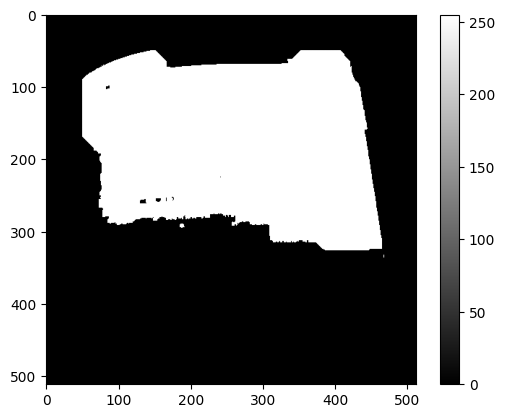

이미지 저장했음


In [4]:
# 생성된 마스크의 객체가 있는 위치는 
# 흰색(값 1), 배경은 검은색(값 0)으로 표시되는 이진 이미지로 변환하는것과
# 같은이름으로 저장하는것 구현함
import sys
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

image_path= './img_data/2QzDgg_3.png'

img = cv.imread(image_path)
assert img is not None, "file could not be read, check with os.path.exists()"
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

# 지사각형 지정 => 마우스로 좌표 클릭 기능 추가 하면 될듯 
img.shape # (512, 512, 3) 이크기안에 들어오면됨
#        x1, y1 x2 y2
rect = (50,50,450,290)

cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8') *255

# 이렇게하면 원본이미지에서 객체 검출
# img = img*mask2[:,:,np.newaxis]
# plt.imshow(img), plt.colorbar(), plt.show()

# 이렇게하면 흑(배경)백(객체)로 추출한거 보기
plt.imshow(mask2, cmap='gray'), plt.colorbar(), plt.show()


# 수정하는 기능 추가해야됨

# 출력 파일 경로 생성
# os.path.basename을 사용하여 파일 이름 추출
# os.path.splitext을 사용하여 파일 이름과 확장자 분리
filename, file_extension = os.path.splitext(os.path.basename(image_path))
output_path = os.path.join('./segmented', filename + file_extension)

if not os.path.exists('./segmented'):
    os.makedirs('./segmented')

# 마스크 저장
cv.imwrite(output_path, mask2)
print('이미지 저장했음')


In [1]:
import sys
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

image_path= './img_data/2QzDgg_3.png'

Blue,Green,Red,Black,White = (255,0,0),(0,255,0),(0,0,255),(0,0,0),(255,255,255)
DRAW_BG = {'color':Black,'val':0}
DRAW_FG = {'color':White,'val':1}

rect = (0,0,1,1)
drawing = False
rectangle = False
rect_over = False
rect_or_mask = 100
value = DRAW_FG
thickness = 3

def onMouse(event,x,y,flags,params):
    global ix, iy, img, img2, drawing, value, mask,rectangle
    global rect, rect_or_mask,rect_over, thickness
    
    if event == cv2.EVENT_MOUSEMOVE and not drawing:
        img = img2.copy()
        # 현재 마우스 위치에 따라 원을 그립니다. 이 원은 현재 thickness 값을 반영합니다.
        cv2.circle(img, (x, y), thickness, (0, 0, 255), 2)  # 마우스 위치에 원을 그림

    if event == cv2.EVENT_RBUTTONDOWN:
        rectangle = True
        ix,iy = x,y

    elif event == cv2.EVENT_MOUSEMOVE:
        if rectangle:
            img = img2.copy()
            cv2.rectangle(img,(ix,iy),(x,y),Red,2)
            rect = (min(ix,x),min(iy,y),abs(ix-x),abs(iy-y))
            rect_or_mask = 0

    elif event == cv2.EVENT_RBUTTONUP:
        rectangle = False
        rect_over = True

        cv2.rectangle(img,(ix,iy),(x,y),Red,2)
        rect = (min(ix,x),min(iy,y),abs(ix-x),abs(iy-y))
        rect_or_mask = 0
        print('n:적용하기')

    if event == cv2.EVENT_LBUTTONDOWN:
        if not rect_over:
            print('마우스 왼쪽을 누른채로 전경이 되는 부분을 선택하시오')
        else:
            drawing = True
            cv2.circle(img,(x,y),thickness,value['color'],-1)
            cv2.circle(mask,(x,y),thickness,value['val'],-1)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.circle(img,(x,y),thickness,value['color'],-1)
            cv2.circle(mask,(x,y),thickness,value['val'],-1)

    elif event == cv2.EVENT_LBUTTONUP:
        if drawing:
            drawing = False
            cv2.circle(img,(x,y),thickness,value['color'],-1)
            cv2.circle(mask,(x,y),thickness,value['val'],-1)
    return


def grapcut():
    global ix, iy, img, img2, drawing, value, mask,rectangle
    global rect, rect_or_mask,rect_over, thickness, image_path

    img = cv2.imread(image_path)
    img2 = img.copy()

    mask = np.zeros(img.shape[:2],dtype=np.uint8)
    output = np.zeros(img.shape,np.uint8)
    
    # 초기 두께 값을 10으로 설정
    thickness = 10

    cv2.namedWindow('input', cv2.WINDOW_NORMAL)
    cv2.namedWindow('output', cv2.WINDOW_NORMAL)
    cv2.namedWindow('mask', cv2.WINDOW_NORMAL)
    cv2.setMouseCallback('input',onMouse,param=(img,img2))
    cv2.moveWindow('input',img.shape[1]+10,90)

    print('오른쪽 마우스 버튼을 누르고 영역을 지정한 후 n을 누르시오')

    while True:
        cv2.imshow('output',output)
        cv2.imshow('input',img)

        k = cv2.waitKey(1) & 0xFF
        
        # esc키누르면 종료
        if k == 27:  
            break
        # '+' 키를 누르면 thickness 증가
        if k == ord(']'):
            thickness += 1
            print(f'현재 두께: {thickness}')

        # '-' 키를 누르면 thickness 감소, 단, thickness는 1보다 작아질 수 없음
        if k == ord('[') and thickness > 1:
            thickness -= 1
            print(f'현재 두께: {thickness}')

        if k == ord('0'):
            print('왼쪽 마우스로 제거할 부분을 표시한 후 n을 누르세요')
            value = DRAW_BG
        elif k == ord('1'):
            print('왼쪽 마우스로 복원할 부분을 표시한 후 n을 누르세요')
            value = DRAW_FG
        elif k == ord('r'):
            print('리셋합니다')
            rect = (0,0,1,1)
            drawing = False
            rectangle = False
            rect_or_mask = 100
            rect_over = False
            value = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2],dtype=uint8)
            output = np.zeros(img.shape,np.uint8)
            print('0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, r:리셋')
        elif k == ord('n'):
            bgdModel = np.zeros((1,65),np.float64)
            fgdModel = np.zeros((1,65),np.float64)

            if rect_or_mask == 0:
                cv2.grabCut(img2,mask,rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_RECT)
                rect_or_mask = 1
            elif rect_or_mask == 1:
                cv2.grabCut(img2,mask,rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_MASK)

            print('0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋')
            print('크기조절 키우기 ], 줄이기 [')
            
            # 업데이트된 마스크를 흑백으로 변환하여 mask2에 저장
            mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8') * 255
            # mask2를 'mask' 윈도우에 표시
            cv2.imshow('mask', mask2)
            
        # 여기에 적당한 마스크 확인 했으면 저장하는 기능 추가해야됨 
        elif k == ord('s'):  # 's' 키를 누르면 실행
            #원본 파일이름과맞추기기
            filename, file_extension = os.path.splitext(os.path.basename(image_path))
            output_path = os.path.join('./seg', filename + file_extension)

            if not os.path.exists('./seg'):
                os.makedirs('./seg')

            # 마스크 저장
            cv2.imwrite(output_path, mask2)
            print(f'마스크 이미지를 {output_path}로 저장했습니다.')
            
            ###새로운 이미지를 불러오기위해 파일선택창을 띄우는 기능을 
            ### 추가해야뎀
            

        mask2 = np.where((mask==1) + (mask == 3),255,0).astype('uint8')
        output = cv2.bitwise_and(img2,img2,mask=mask2)

    cv2.destroyAllWindows()

# esc키 종료
grapcut()

오른쪽 마우스 버튼을 누르고 영역을 지정한 후 n을 누르시오
마우스 왼쪽을 누른채로 전경이 되는 부분을 선택하시오
n:적용하기
n:적용하기
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
왼쪽 마우스로 제거할 부분을 표시한 후 n을 누르세요
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
왼쪽 마우스로 복원할 부분을 표시한 후 n을 누르세요
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
왼쪽 마우스로 제거할 부분을 표시한 후 n을 누르세요
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
왼쪽 마우스로 복원할 부분을 표시한 후 n을 누르세요
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, s:저장, r:리셋
크기조절 키우기 ], 줄이기 [
마스크 이미지를 